Import all necessary packages

In [3]:
import numpy as np ### numpy for array modifications
import pandas as pd ### pandas for dataframe handling
import seaborn as sns ### seaborn for data vis
from sklearn.linear_model import LinearRegression ### regression model from skleanr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import re
import matplotlib.pyplot as plt

from nba_api.stats.static import players ### all nba players -- not box score data, just player IDs
from nba_api.stats.static import teams ### all nba teams -- not box score data, just teans IDs
from nba_api.stats.endpoints import playergamelog ### player game stats
from nba_api.stats.endpoints import leaguegamefinder ### team game stats
from nba_api.stats.endpoints import teamgamelog ### team game logs
from nba_api.stats.endpoints import commonplayerinfo

Creating a dictionary of all players all time.

In [4]:
player_dict = players.get_players() 

Creating a dictionary of all active players.

In [5]:
active_player_dict = [player for player in player_dict if player['is_active'] ==  True]

A function that finds the player id given the player name.

The parameter player_name is a string.

The output is the corresponding players's id as an int.

In [6]:
def player_id_finder(player_name):
    for player in active_player_dict:
        if player['full_name'] == player_name:
            return player['id']

The below creates a dictionary, pairing each team's abbreviation with the full team name.

In [7]:
x = ['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
y = ['Atlanta Hawks','Boston Celtics','Brooklyn Nets','Charlotte Hornets','Chicago Bulls','Cleveland Cavaliers','Dallas Mavericks','Denver Nuggets','Detroit Pistons','Golden State Warriors','Houston Rockets','Indiana Pacers','Los Angeles Clippers','Los Angeles Lakers','Memphis Grizzlies','Miami Heat','Milwaukee Bucks','Minnesota Timberwolves','New Orleans Pelicans','New York Knicks','Oklahoma City Thunder','Orlando Magic','Philadelphia 76ers','Phoenix Suns','Portland Trail Blazers','Sacramento Kings','San Antonio Spurs','Toronto Raptors', 'Utah Jazz', 'Washington Wizards']
team_name_dict = {k:v for k, v in zip(x,y)}

Creating a dictionary of all teams.

In [8]:
team_dict = teams.get_teams()

A function that finds the team id given the team name.

The parameter team_name is a string.

The output is the corresponding team's id as an int.

In [9]:
def team_id_finder(team_name):
    for team in team_dict:
        if team['full_name'] == team_name:
            return team['id']

A function that saves team data by season as a csv file.

The parameters
- seasons_list: list (of seasons in format [20xx-xx, 20xx-xx, ...]
- season_type: str ('Regular Season', 'Playoffs')

The Output
- saves the dataframe created from the API call as a csv file (no output)

In [10]:
def save_team_datasets(seasons_list, season_type):
    for season in seasons_list:
        print('loading season', season)
        df = leaguegamefinder.LeagueGameFinder(season_nullable = season, league_id_nullable = '00', season_type_nullable = season_type).get_data_frames()[0]
        filename = str(season) + 'teams' + re.match(r'^\w+', season_type).group(0) + '.csv'
        print(filename)
        df.to_csv(filename, index=False)
        print('Successully saved', filename)

In [11]:
def save_player_datasets(seasons_list, season_type):
    for season in seasons_list:
        print('loading season', season)
        df = leaguegamefinder.LeagueGameFinder(player_or_team_abbreviation='P' ,season_nullable = season, league_id_nullable = '00', season_type_nullable = season_type).get_data_frames()[0]
        filename = str(season) + 'players' + re.match(r'^\w+', season_type).group(0) + '.csv'
        print(filename)
        df.to_csv(filename, index=False)
        print('Successully saved', filename)

Using a call from nba_api to download player and team data from the past 5 seasons from the regular season and playoffs as csv files.

Saving the csv files from the most recent (2023) season as dataframe variables.

In [12]:
seasons_list = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23']

#save_team_datasets(seasons_list, 'Regular Season')

In [13]:
#save_player_datasets(seasons_list, 'Regular Season')

In [14]:
players_2023 = pd.read_csv('2022-23playersRegular.csv')

In [15]:
teams_2023 = pd.read_csv('2022-23teamsRegular.csv')

In [16]:
#save_team_datasets(seasons_list, 'Playoffs')

In [17]:
#save_player_datasets(seasons_list, 'Playoffs')

In [18]:
players_2023_playoffs = pd.read_csv('2022-23playersPlayoffs.csv')

In [19]:
teams_2023_playoffs = pd.read_csv('2022-23teamsPlayoffs.csv')

A function that compares a player's offensive stats (pt, reb, ast) to the opponents defensive rating. The function returns regression plots showing how well of a predictor opponent defensive rating is for the player's offensive stats.

The parameters
- player name: str
- players_df: pandas dataframe (of players' stats data)
- teams_df: pandas dataframe (of teams' stats data)

The output

- Three regression plots that graph opponent defensive rating (x) against player offenseive stats (y)
- R-squared values of the models to gauge performance

In [20]:
def player_off_trends(player_name, players_df, teams_df):
    #retrieve the players stats from the player_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()

    #retrieve the ids of the games the player played in
    player_game_ids = list(player_df['GAME_ID'])

    #retreieve the stats from the teams in all the games the player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()

    #create a set of player team ids --> incase they are traded midseason and play for different teams
    player_team_id_set = set(list(player_df['TEAM_ID']))
    
    #calculate the opposing team's defensive rating (opponent's points)/(possesions) * 100 where possesions = (FGA - OREB + TOV + (FTA * 0.4))
    team_pts = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['PTS'])
    team_fga = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['FGA'])
    team_oreb = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['OREB'])
    team_tov = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['TOV'])
    team_fta = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['FTA'])

    opp_def_ratings = (team_pts)/(team_fga - team_oreb + team_tov + (team_fta * 0.4)) * 100

    #create a dictionary mapping the game ids to the def ratings.
    id_def_rating_dict = {k:v for k,v in zip(player_game_ids, opp_def_ratings)}

    #map the opponent defensive rating onto player_df
    player_df.loc[:, 'opp_def_rating'] = player_df['GAME_ID'].map(id_def_rating_dict)

    #plot regression lines and find basic stats.
    x = np.array(player_df['opp_def_rating']).reshape(-1, 1)
    
    sns.lmplot(data=player_df, x='opp_def_rating', y='PTS')
    y1 = list(player_df['PTS'])
    pts_model = LinearRegression().fit(x, y1)
    print('R-squared for pts:', pts_model.score(x,y1))
    
    sns.lmplot(data=player_df, x='opp_def_rating', y='REB')
    y2 = list(player_df['REB'])
    pts_model = LinearRegression().fit(x, y2)
    print('R-squared for reb:', pts_model.score(x,y2))
          
    sns.lmplot(data=player_df, x='opp_def_rating', y='AST')
    y3 = list(player_df['AST'])
    pts_model = LinearRegression().fit(x, y3)
    print('R-squared for ast:', pts_model.score(x,y3))

Example of player_off_trends

R-squared for pts: 0.14587291666493474
R-squared for reb: 0.0031029437604026544
R-squared for ast: 0.11544092990068389


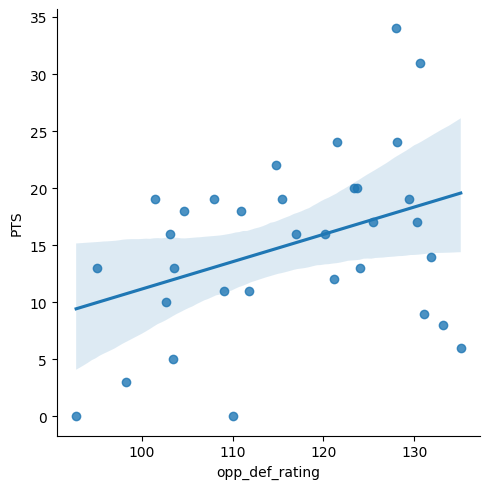

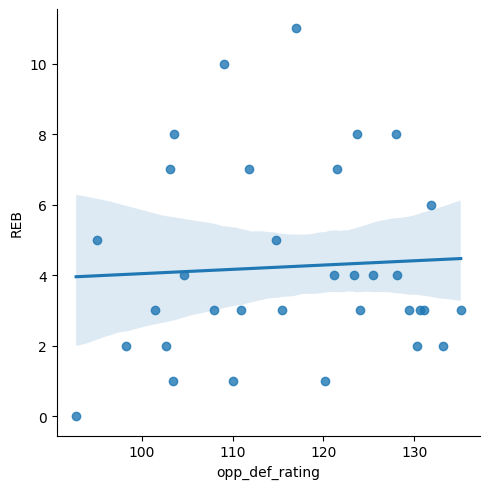

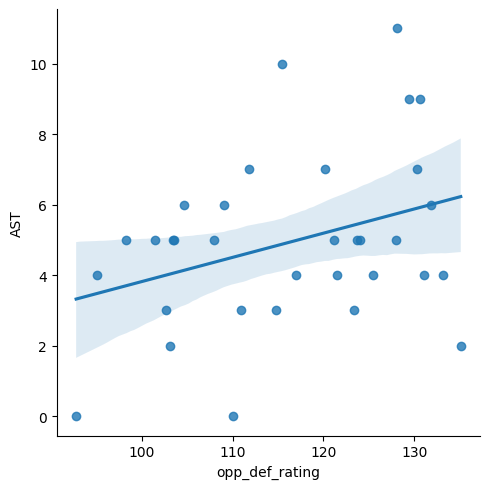

In [21]:
player_off_trends('Khris Middleton', players_2023, teams_2023)

A function that compares a players' points scored and the fraction of the team's points that they scored. The function returns a regression plot displaying the performance of the fraction of the team's points scored as a predictor for points scored.

The parameters:
- player name: str
- players_df: pandas dataframe (of players' stats data)
- teams_df: pandas dataframe (of teams' stats data)

The output

- A regression plot that graphs fraction of points scored (x) against points scored (y)
- R-squared value of the models to gauge performance

In [22]:
def player_team_point_comp(player_name, players_df, teams_df):
    player_df = players_2023[players_2023['PLAYER_NAME'] == player_name].copy()

    player_game_ids = list(player_df['GAME_ID'])
    player_team_ids = set(list(player_df['TEAM_ID']))
    player_games = teams_2023[teams_2023['GAME_ID'].isin(player_game_ids)].copy()
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)]
    team_points = list(player_team_games['PTS'])

    player_team_points_dict = {k:v for k,v in zip(player_game_ids, team_points)}

    player_df.loc[:, 'team_score'] = player_df['GAME_ID'].map(player_team_points_dict)
    player_df.loc[:, 'player/team'] = player_df['PTS']/player_df['team_score']

    x= np.array(player_df['player/team']).reshape(-1,1)
    
    y= np.array(player_df['PTS'])

    sns.lmplot(data=player_df, x='player/team', y='PTS')
    model = LinearRegression().fit(x,y)
    print('R-Squared:', model.score(x,y))
    
    

R-Squared: 0.8658229809053406


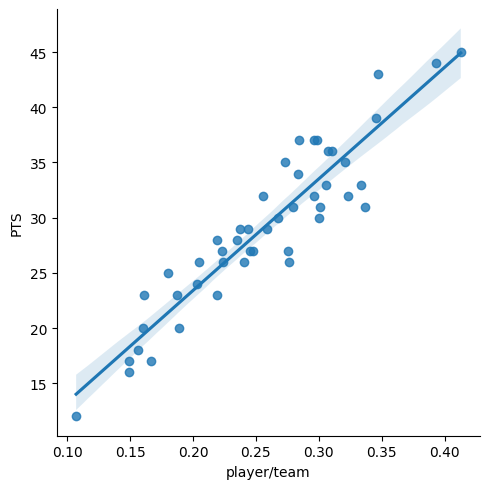

In [23]:
player_team_point_comp('Kevin Durant', players_2023, teams_2023)

A function that compares a players' points scored and the fraction of the team's field goals that they attempted. The function returns a regression plot displaying the performance of the fraction of the team's field goals attempted as a predictor for points scored.

The parameters:
- player name: str
- players_df: pandas dataframe (of players' stats data)
- teams_df: pandas dataframe (of teams' stats data)

The output

- A regression plot that graphs fraction of field goals attempted (x) against points scored (y)
- R-squared value of the models to gauge performance

In [24]:
def player_points_percent_fga_comp(player_name, players_df, teams_df):
    player_df = players_2023[players_2023['PLAYER_NAME'] == player_name].copy()

    player_game_ids = list(player_df['GAME_ID'])
    player_team_ids = set(list(player_df['TEAM_ID']))
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)]
    team_fga = list(player_team_games['FGA'])

    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}

    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    player_df.loc[:, 'player/team'] = player_df['FGA']/player_df['team_fga']

    x= np.array(player_df['player/team']).reshape(-1,1)
    
    y= np.array(player_df['PTS'])

    sns.lmplot(data=player_df, x='player/team', y='PTS')
    model = LinearRegression().fit(x,y)
    print('R-Squared:', model.score(x,y))
    

R-Squared: 0.4413958849775853


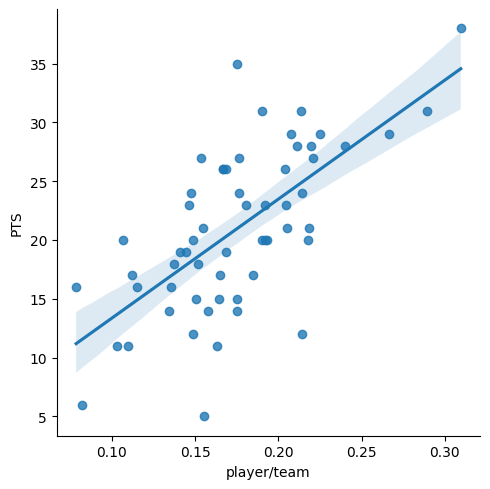

In [25]:
player_points_percent_fga_comp('James Harden', players_2023, teams_2023)

A function that compares a team's steals recorded and the amount of turnovers commited by the opponent. The function returns a regression plot displaying the performance of opponent turnovers as a predictor for team steals.

The parameters:
- team_name: str
- teams_df: pandas dataframe (of teams' stats data)

The output

- A regression plot that graphs opponent turnvoers (x) against team steals (y)
- R-squared value of the models to gauge performance

In [26]:
def stl_tov_trends(team_name, teams_df):

    #retrieve the stats from the teams in all the games the team played in
    team_games = teams_df[teams_df['TEAM_NAME']==team_name].copy()
    team_game_ids = list(team_games['GAME_ID'])
    opp_team_games = teams_df[teams_df['GAME_ID'].isin(team_game_ids)].copy()
    opp_team_tovs = opp_team_games[opp_team_games['TEAM_ID'] != team_id_finder(team_name)]
    
    #retrieve turnovers and steals
    
    opp_tovs = np.array(opp_team_tovs['TOV'])
    
                                       
    #create a dictionary mapping the game ids to the def ratings.
    id_tov_stl_dict = {k:v for k,v in zip(team_game_ids, opp_tovs)}

    #map the opponent defensive rating onto player_df
    team_games.loc[:, 'opp_tovs'] = team_games['GAME_ID'].map(id_tov_stl_dict)

    #plot regression lines and find basic stats.
    x = np.array(team_games['opp_tovs']).reshape(-1, 1)
    y = np.array(team_games['STL'])
    
    sns.lmplot(data=team_games, x='opp_tovs', y='STL')
    stls_model = LinearRegression().fit(x, y)
    print('R-squared:', stls_model.score(x,y))

R-squared: 0.5821400323556429


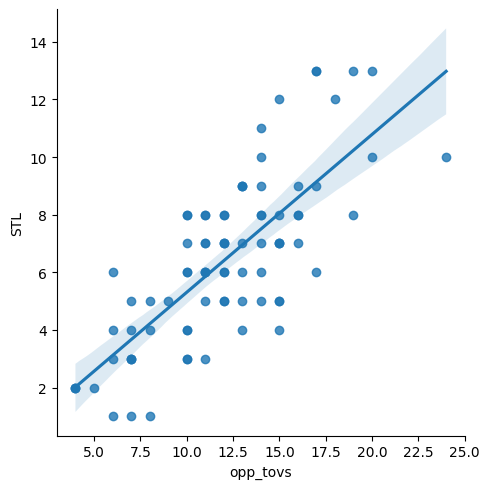

In [27]:
stl_tov_trends('New York Knicks', teams_2023)

In [28]:
def player_points_percent_fta_comp(player_name, players_df, teams_df):
    player_df = players_2023[players_2023['PLAYER_NAME'] == player_name]

    player_game_ids = list(player_df['GAME_ID'])
    player_team_ids = set(list(player_df['TEAM_ID']))
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)]
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)]
    team_fta = list(player_team_games['FTA'])

    game_id_team_fta_dict = {k:v for k,v in zip(player_game_ids, team_fta)}

    player_df['team_fta'] = player_df['GAME_ID'].map(game_id_team_fta_dict)
    player_df['player/team'] = player_df['FTA']/player_df['team_fta']

    x= np.array(player_df['player/team']).reshape(-1,1)
    
    y= np.array(player_df['PTS'])

    sns.lmplot(data=player_df, x='player/team', y='PTS')
    model = LinearRegression().fit(x,y)
    print('% of team fta vs player points:', model.score(x,y))
     

% of team fta vs player points: 0.40079492247259096


/var/folders/t_/6pr35fg96s7cpgmqrdcyy3p40000gq/T/ipykernel_11685/2294196067.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['team_fta'] = player_df['GAME_ID'].map(game_id_team_fta_dict)
/var/folders/t_/6pr35fg96s7cpgmqrdcyy3p40000gq/T/ipykernel_11685/2294196067.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['player/team'] = player_df['FTA']/player_df['team_fta']


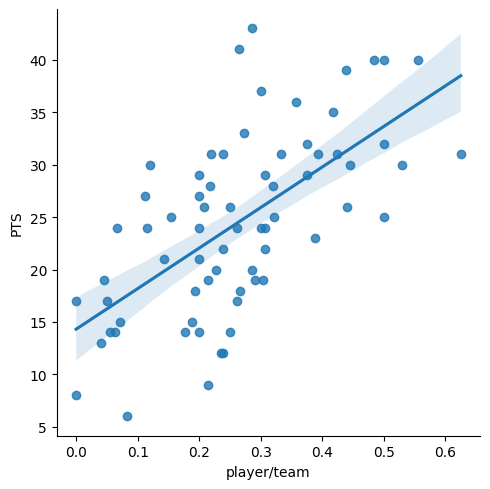

In [29]:
player_points_percent_fta_comp('Nikola Jokic', players_2023, teams_2023)

In [30]:
def player_points_vs_efgp(player_name, players_df):
    player_df = players_df[players_df['PLAYER_NAME'] == player_name]
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df['eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    player_df['eFG%'] = player_df['eFG%'].fillna(0)
    
    sns.lmplot(data=player_df, x='eFG%', y='PTS')
    
    x = np.array(player_df['eFG%']).reshape(-1,1)
    y = np.array(player_df['PTS'])
    
    model = LinearRegression().fit(x, y)
    print('R-squared for eFG% vs PTS:', model.score(x,y))

/var/folders/t_/6pr35fg96s7cpgmqrdcyy3p40000gq/T/ipykernel_11685/2578098072.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
/var/folders/t_/6pr35fg96s7cpgmqrdcyy3p40000gq/T/ipykernel_11685/2578098072.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['eFG%'] = player_df['eFG%'].fillna(0)


R-squared for eFG% vs PTS: 0.44422198974582916


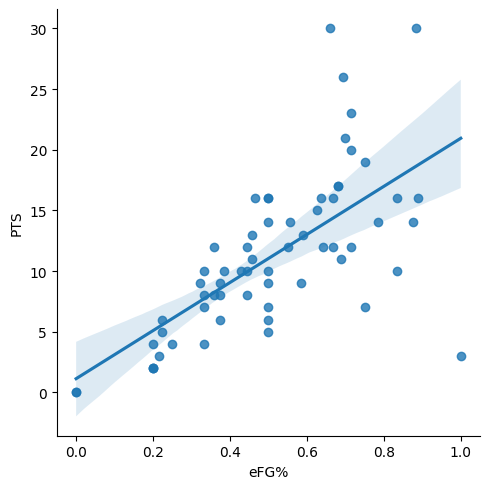

In [31]:
player_points_vs_efgp('Rui Hachimura', players_2023)

In [32]:
def player_points_prediction_model(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the players eFG% (FACTOR 2)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    #define the variables
    x = player_df[['playerFGA%', 'eFG%', 'FTA', 'FT_PCT']].fillna(0)
    y = player_df['PTS']
    
    model = LinearRegression().fit(x,y)
    
    return model

In [33]:
bron_points_model = player_points_prediction_model('LeBron James', players_2023, teams_2023)

In [34]:
bron_points_model.predict([[0.20, 0.65, 5, 0.70]])

/Users/rafirafi/Desktop/git-repos/nba-sports-betting-predictor-1/nba-predictions/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([27.64282324])

In [35]:
def player_points_prediction_test_data(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the players eFG% (FACTOR 2)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    return player_df

In [36]:
def test_prediction_model(player_name, playersRegular_df, teamsRegular_df, playersPlayoff_df, teamsPlayoff_df, prediction_model, test_data):
    # create model
    model = prediction_model(player_name, playersRegular_df, teamsRegular_df)
    
    # extract playoff test data
    test_df = test_data(player_name, playersPlayoff_df, teamsPlayoff_df)
    
    # collect x and y test data. 
    # X is the data that we feed into the model. 
    # Y is the actual outcome to compare against the predicted values.
    x_test = test_df[['playerFGA%', 'eFG%', 'FTA', 'FT_PCT']].fillna(0)
    y_test = np.array(test_df['PTS'])
    
    # Generate the predictions.
    y_pred = model.predict(x_test)
    
    # Create a graph to visualize the results
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Points scored by' + player_name)
    plt.ylabel('Predicted Points scored by' +  player_name)
    plt.show()
    
    #Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print('Mean Squared Error:', mse)
    
    #Calculate the R-Squared
    r2 = r2_score(y_test, y_pred)
    print('R-squared:', r2)

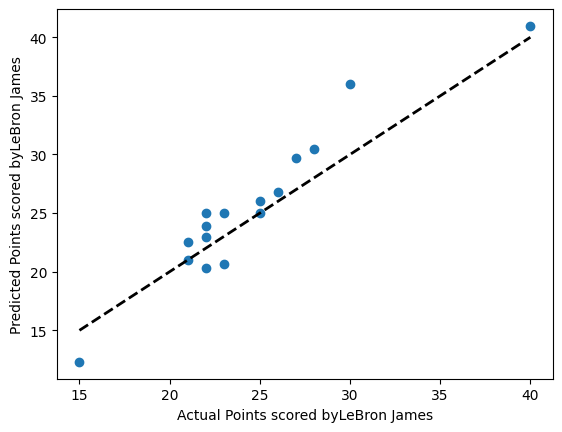

Mean Squared Error: 5.473241597933113
R-squared: 0.7991470973235555


In [37]:
test_prediction_model('LeBron James', players_2023, teams_2023, players_2023_playoffs, teams_2023_playoffs, player_points_prediction_model, player_points_prediction_test_data)

In [38]:
def stl_tov_trends(player_name, players_df, teams_df):

    #retrieve the stats from the teams in all the games the team played in
    team_games = teams_df[teams_df['TEAM_NAME']==team_name].copy()
    team_game_ids = list(team_games['GAME_ID'])
    opp_team_games = teams_df[teams_df['GAME_ID'].isin(team_game_ids)].copy()
    opp_team_tovs = opp_team_games[opp_team_games['TEAM_ID'] != team_id_finder(team_name)]
    
    #retrieve turnovers and steals
    
    opp_tovs = np.array(opp_team_tovs['TOV'])
    
                                       
    #create a dictionary mapping the game ids to the def ratings.
    id_tov_stl_dict = {k:v for k,v in zip(team_game_ids, opp_tovs)}

    #map the opponent defensive rating onto player_df
    team_games.loc[:, 'opp_tovs'] = team_games['GAME_ID'].map(id_tov_stl_dict)

    #plot regression lines and find basic stats.
    x = np.array(team_games['opp_tovs']).reshape(-1, 1)
    y = np.array(team_games['STL'])
    
    sns.lmplot(data=team_games, x='opp_tovs', y='STL')
    stls_model = LinearRegression().fit(x, y)
    print('R-squared:', stls_model.score(x,y))

In [61]:
def blk_fgp_trend(player_name, team_name, players_df, teams_df):

    #retrieve the stats from the teams in all the games the team played in
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    team_games = teams_df[teams_df['TEAM_NAME']==team_name].copy()
    team_game_ids = list(team_games['GAME_ID'])
    opp_team_games = teams_df[teams_df['GAME_ID'].isin(team_game_ids)].copy()
    opp_team_blks = opp_team_games[opp_team_games['TEAM_ID'] != team_id_finder(team_name)]
    
    
    #retrieve blocks
    
    opp_blks = np.array(opp_team_blks['BLK'])
    
                                       
    #create a dictionary mapping the game ids to the def ratings.
    id_blk_fgp_dict = {k:v for k,v in zip(team_game_ids, opp_blks)}

    #map the opponent defensive rating onto player_df
    team_games.loc[:, 'opp_blks'] = team_games['GAME_ID'].map(id_blk_fgp_dict)

    #plot regression lines and find basic stats.
    x = np.array(team_games['opp_blks']).reshape(-1, 1)
    y = np.array(team_games['FG_PCT'])
    
    sns.lmplot(data=team_games, x='opp_blks', y='FG_PCT')
    stls_model = LinearRegression().fit(x, y)
    print('R-squared:', stls_model.score(x,y))

R-squared: 0.08350368177798018


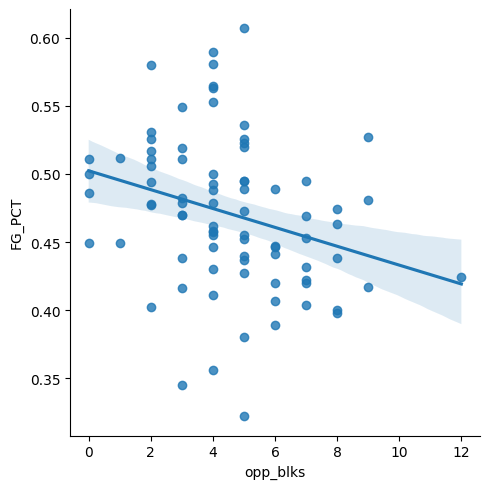

In [62]:
blk_fgp_trend('LeBron James', 'New York Knicks', players_2023, teams_2023)

pace to possession?
like try to see if there is any correlation between teams running up the shot clock and defense